In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import glob
import yahist
from matplotlib.collections import LineCollection

In [2]:
yahist.utils.set_default_style()

In [3]:
fname = "../sources/nytimes/data/cases.json.gz"
df_total = pd.read_json(fname)
df_total["date"] = pd.to_datetime(df_total["date"])
df_total = df_total.sort_values(["date"])

df_total["place"] = df_total["county"].str.cat(df_total["state"], sep=", ")
df_cases = df_total.reset_index(drop=True)

def get(key, avg_over=1):
    # average over last `avg_over` days (1 means instantaneous/no averaging)
    return pd.pivot_table(
        df_total.groupby(["date",key])["cases"].sum().reset_index(),
        values = "cases",
        index = "date",
        columns = key,
    ).fillna(0.).rolling(avg_over,center=False).mean()

avg_over = 5
df_counties = get("place", avg_over=avg_over)
df_states = get("state", avg_over=avg_over)

In [4]:
df_states

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-21,12565.0,399.6,14577.0,4991.2,84180.6,22493.4,38438.0,8031.2,7433.2,47016.0,...,18192.6,51064.0,7549.0,943.6,69.0,32143.6,19689.0,1535.2,13167.0,776.8
2020-05-22,12944.8,401.2,14911.2,5161.8,86267.6,22802.8,38882.2,8203.0,7587.2,47788.6,...,18587.2,52172.2,7712.8,946.0,69.0,33056.0,19887.6,1578.2,13564.2,786.6
2020-05-23,13357.4,403.2,15285.2,5354.2,88442.0,23154.4,39263.4,8367.2,7726.4,48525.6,...,18986.8,53304.8,7888.0,948.8,69.0,33977.8,20080.8,1623.6,14016.8,796.0


In [5]:
def plot(max_date="2020-04-17", regions="states", frac=1.0, alpha_lines=0.25, alpha_markers=0.6, fname=None):
     # frac = 1.0 means take the latest point, 0.0 means take the previous point
    if regions == "states":
        dfcurr = df_states
    if regions == "counties":
        dfcurr = df_counties
        alpha_lines=0.01
        alpha_markers = 0.1
    dfdiff = dfcurr.diff()
    
    prev_date = str(pd.Timestamp(max_date)-pd.Timedelta("1 day")).split()[0]

    lines = []
    for place in dfcurr.columns:
        cases = dfcurr[place].loc[:max_date]
        newcases = dfdiff[place].loc[:max_date]
        line = np.array(np.c_[cases,newcases][1:,:])
        line[-1] = frac*line[-1] + (1-frac)*line[-2]
        lines.append(line)

    lc = LineCollection(lines, color="gray", lw=1, alpha=alpha_lines)

    fig, ax = plt.subplots()
    ax.add_collection(lc)
    xs = frac*dfcurr.loc[max_date] + (1-frac)*dfcurr.loc[prev_date]
    ys = frac*dfdiff.loc[max_date] + (1-frac)*dfdiff.loc[prev_date]
    ax.scatter(xs,ys,s = 8.0,color="black",alpha=alpha_markers)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1,1e6])
    ax.set_ylim([1,1e6])
    ax.set_xlabel("current cumulative cases")
    ax.set_ylabel(f"new cases (avg over {avg_over} day(s))")
    ax.set_title(f"cases in {regions} up to {max_date}")
    ax.grid(alpha=0.25)
    
    if fname:
        fig.savefig(fname)
        plt.close()


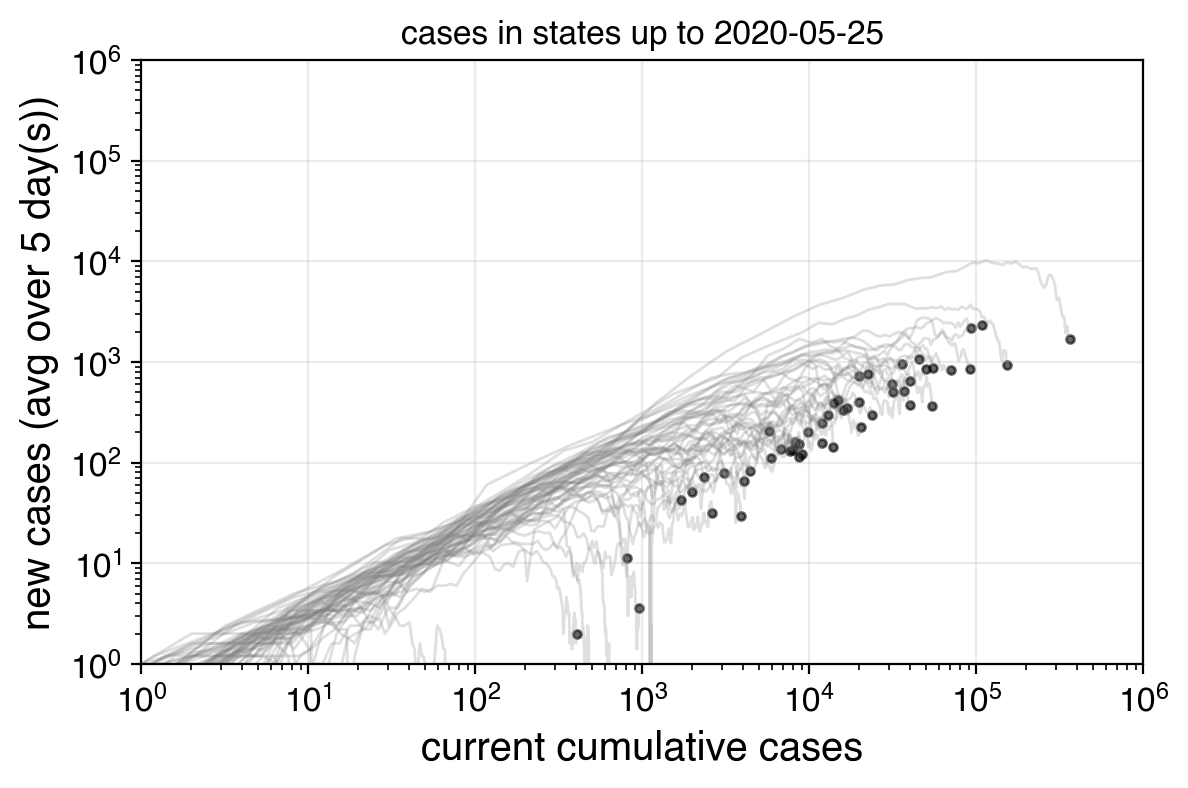

In [6]:
plot(max_date=f"2020-05-25", regions="states", frac=1.0)
# plot(max_date=f"2020-05-03", regions="counties", frac=1.0)

In [7]:
!mkdir -p plot_trajectories/
!rm plot_trajectories/*.png

regions = "states"
# regions = "counties"

dates = pd.date_range("2020-02-12","2020-05-17",freq="D").strftime("%Y-%m-%d")
for date in dates:
    for frac in np.linspace(0,0.9,10):
        # frac 0 does the previous day, so we start with 0.0 to 0.9, then 
        # when i increments, it's the next day
        ifrac = int(frac*10)
        fname = f"plot_trajectories/plot_{date}_{ifrac}.png"
        print(fname)
        plot(max_date=date, frac=frac, regions=regions, fname=fname)


plot_trajectories/plot_2020-02-12_0.png
plot_trajectories/plot_2020-02-12_1.png
plot_trajectories/plot_2020-02-12_2.png
plot_trajectories/plot_2020-02-12_3.png
plot_trajectories/plot_2020-02-12_4.png
plot_trajectories/plot_2020-02-12_5.png
plot_trajectories/plot_2020-02-12_6.png
plot_trajectories/plot_2020-02-12_7.png
plot_trajectories/plot_2020-02-12_8.png
plot_trajectories/plot_2020-02-12_9.png
plot_trajectories/plot_2020-02-13_0.png
plot_trajectories/plot_2020-02-13_1.png
plot_trajectories/plot_2020-02-13_2.png
plot_trajectories/plot_2020-02-13_3.png
plot_trajectories/plot_2020-02-13_4.png
plot_trajectories/plot_2020-02-13_5.png
plot_trajectories/plot_2020-02-13_6.png
plot_trajectories/plot_2020-02-13_7.png
plot_trajectories/plot_2020-02-13_8.png
plot_trajectories/plot_2020-02-13_9.png
plot_trajectories/plot_2020-02-14_0.png
plot_trajectories/plot_2020-02-14_1.png
plot_trajectories/plot_2020-02-14_2.png
plot_trajectories/plot_2020-02-14_3.png
plot_trajectories/plot_2020-02-14_4.png


plot_trajectories/plot_2020-03-03_5.png
plot_trajectories/plot_2020-03-03_6.png
plot_trajectories/plot_2020-03-03_7.png
plot_trajectories/plot_2020-03-03_8.png
plot_trajectories/plot_2020-03-03_9.png
plot_trajectories/plot_2020-03-04_0.png
plot_trajectories/plot_2020-03-04_1.png
plot_trajectories/plot_2020-03-04_2.png
plot_trajectories/plot_2020-03-04_3.png
plot_trajectories/plot_2020-03-04_4.png
plot_trajectories/plot_2020-03-04_5.png
plot_trajectories/plot_2020-03-04_6.png
plot_trajectories/plot_2020-03-04_7.png
plot_trajectories/plot_2020-03-04_8.png
plot_trajectories/plot_2020-03-04_9.png
plot_trajectories/plot_2020-03-05_0.png
plot_trajectories/plot_2020-03-05_1.png
plot_trajectories/plot_2020-03-05_2.png
plot_trajectories/plot_2020-03-05_3.png
plot_trajectories/plot_2020-03-05_4.png
plot_trajectories/plot_2020-03-05_5.png
plot_trajectories/plot_2020-03-05_6.png
plot_trajectories/plot_2020-03-05_7.png
plot_trajectories/plot_2020-03-05_8.png
plot_trajectories/plot_2020-03-05_9.png


plot_trajectories/plot_2020-03-24_0.png
plot_trajectories/plot_2020-03-24_1.png
plot_trajectories/plot_2020-03-24_2.png
plot_trajectories/plot_2020-03-24_3.png
plot_trajectories/plot_2020-03-24_4.png
plot_trajectories/plot_2020-03-24_5.png
plot_trajectories/plot_2020-03-24_6.png
plot_trajectories/plot_2020-03-24_7.png
plot_trajectories/plot_2020-03-24_8.png
plot_trajectories/plot_2020-03-24_9.png
plot_trajectories/plot_2020-03-25_0.png
plot_trajectories/plot_2020-03-25_1.png
plot_trajectories/plot_2020-03-25_2.png
plot_trajectories/plot_2020-03-25_3.png
plot_trajectories/plot_2020-03-25_4.png
plot_trajectories/plot_2020-03-25_5.png
plot_trajectories/plot_2020-03-25_6.png
plot_trajectories/plot_2020-03-25_7.png
plot_trajectories/plot_2020-03-25_8.png
plot_trajectories/plot_2020-03-25_9.png
plot_trajectories/plot_2020-03-26_0.png
plot_trajectories/plot_2020-03-26_1.png
plot_trajectories/plot_2020-03-26_2.png
plot_trajectories/plot_2020-03-26_3.png
plot_trajectories/plot_2020-03-26_4.png


plot_trajectories/plot_2020-04-13_5.png
plot_trajectories/plot_2020-04-13_6.png
plot_trajectories/plot_2020-04-13_7.png
plot_trajectories/plot_2020-04-13_8.png
plot_trajectories/plot_2020-04-13_9.png
plot_trajectories/plot_2020-04-14_0.png
plot_trajectories/plot_2020-04-14_1.png
plot_trajectories/plot_2020-04-14_2.png
plot_trajectories/plot_2020-04-14_3.png
plot_trajectories/plot_2020-04-14_4.png
plot_trajectories/plot_2020-04-14_5.png
plot_trajectories/plot_2020-04-14_6.png
plot_trajectories/plot_2020-04-14_7.png
plot_trajectories/plot_2020-04-14_8.png
plot_trajectories/plot_2020-04-14_9.png
plot_trajectories/plot_2020-04-15_0.png
plot_trajectories/plot_2020-04-15_1.png
plot_trajectories/plot_2020-04-15_2.png
plot_trajectories/plot_2020-04-15_3.png
plot_trajectories/plot_2020-04-15_4.png
plot_trajectories/plot_2020-04-15_5.png
plot_trajectories/plot_2020-04-15_6.png
plot_trajectories/plot_2020-04-15_7.png
plot_trajectories/plot_2020-04-15_8.png
plot_trajectories/plot_2020-04-15_9.png


plot_trajectories/plot_2020-05-04_0.png
plot_trajectories/plot_2020-05-04_1.png
plot_trajectories/plot_2020-05-04_2.png
plot_trajectories/plot_2020-05-04_3.png
plot_trajectories/plot_2020-05-04_4.png
plot_trajectories/plot_2020-05-04_5.png
plot_trajectories/plot_2020-05-04_6.png
plot_trajectories/plot_2020-05-04_7.png
plot_trajectories/plot_2020-05-04_8.png
plot_trajectories/plot_2020-05-04_9.png
plot_trajectories/plot_2020-05-05_0.png
plot_trajectories/plot_2020-05-05_1.png
plot_trajectories/plot_2020-05-05_2.png
plot_trajectories/plot_2020-05-05_3.png
plot_trajectories/plot_2020-05-05_4.png
plot_trajectories/plot_2020-05-05_5.png
plot_trajectories/plot_2020-05-05_6.png
plot_trajectories/plot_2020-05-05_7.png
plot_trajectories/plot_2020-05-05_8.png
plot_trajectories/plot_2020-05-05_9.png
plot_trajectories/plot_2020-05-06_0.png
plot_trajectories/plot_2020-05-06_1.png
plot_trajectories/plot_2020-05-06_2.png
plot_trajectories/plot_2020-05-06_3.png
plot_trajectories/plot_2020-05-06_4.png


In [8]:
!ffmpeg -y -r 25 -f image2 -pattern_type glob -i 'plot_trajectories/*.png'  -vcodec libx264 -crf 15  -pix_fmt yuv420p trajectories_{regions}.mp4
!web trajectories_{regions}.mp4

ffmpeg version 4.1.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple LLVM version 10.0.0 (clang-1000.11.45.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.1.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags='-I/Library/Java/JavaVirtualMachines/openjdk-11.0.2.jdk/Contents/Home/include -I/Library/Java/JavaVirtualMachines/openjdk-11.0.2.jdk/Contents/Home/include/darwin' --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-videotoolbox --disa

In [9]:
import time
time.sleep(2)

In [10]:
from IPython.display import HTML
HTML(f"""
    <video alt="test" controls autoplay>
        <source src="trajectories_{regions}.mp4" type="video/mp4">
    </video>
""")

In [30]:
# df_states